In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.vision.all import *
from efficientnet_pytorch import EfficientNet

In [3]:
np.random.seed(1773)

In [4]:
md_ef = EfficientNet.from_pretrained('efficientnet-b0', num_classes=4)

Loaded pretrained weights for efficientnet-b0


In [5]:
CSV_PATH = "/home/ubuntu/auto/dataset/train.csv"
df = pd.read_csv(CSV_PATH)

In [72]:
exp_time = str(datetime.now().replace(second=0, microsecond=0)).replace(" ", "_")
SIZE = 225
BS = 16
GPU = 1
EXP_NAME = "{}-{}-{}".format(BS, SIZE, exp_time)
print(EXP_NAME)

16-225-2020-04-04_11:30:00


In [8]:
stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

In [9]:
item_tfms = [Resize(SIZE)]

In [10]:
dls = ImageDataLoaders.from_df(df=df, path="/home/ubuntu/auto/dataset/train", 
                                item_tfms=item_tfms, valid_pct=0.2,
                                bs=BS, num_workers=16, device=GPU)

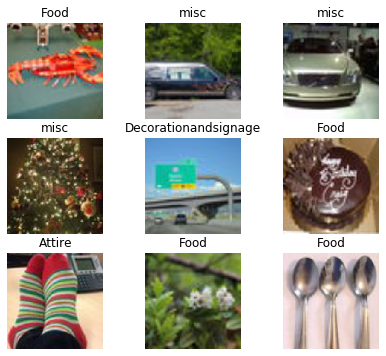

In [11]:
dls.show_batch(max_n=9, figsize=(7,6))

In [12]:
print(dls.vocab)
len(dls.vocab),dls.c

(#4) ['Attire','Decorationandsignage','Food','misc']


(4, 4)

In [16]:
learn = Learner(dls, md_ef, metrics=[error_rate, accuracy], opt_func=ranger)

In [17]:
learn.freeze()

In [20]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.656458,1.285997,0.357023,0.642977,00:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.377246,0.516241,0.175585,0.824415,00:31
1,0.418995,0.618510,0.225753,0.774247,00:32
2,0.402952,0.816788,0.251672,0.748328,00:31
3,0.310939,0.822429,0.229097,0.770903,00:32
4,0.249669,0.868942,0.220736,0.779264,00:31
5,0.160776,0.673594,0.185619,0.814381,00:31
6,0.163205,0.750321,0.194816,0.805184,00:31
7,0.072830,0.780524,0.191472,0.808528,00:32
8,0.055679,0.789866,0.192308,0.807692,00:31
9,0.064159,0.801172,0.193144,0.806856,00:32


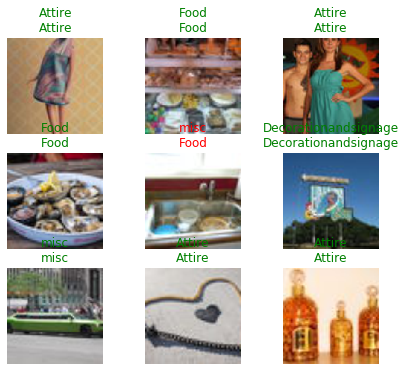

In [21]:
learn.show_results(figsize=(7,6))

[('misc', 'Food', 46),
 ('Attire', 'Food', 35),
 ('Food', 'misc', 28),
 ('misc', 'Attire', 26),
 ('Food', 'Attire', 24),
 ('Attire', 'misc', 17),
 ('Decorationandsignage', 'Food', 11),
 ('Decorationandsignage', 'misc', 11),
 ('Food', 'Decorationandsignage', 11),
 ('misc', 'Decorationandsignage', 10)]

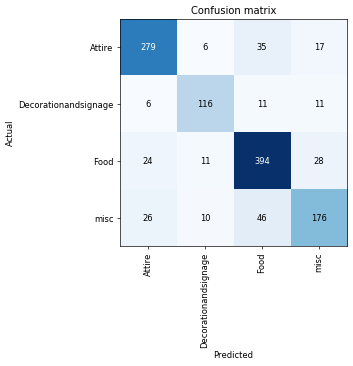

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(7,6), dpi=60)
interp.most_confused(min_val=10)

In [23]:
path = "/home/ubuntu/auto/dataset/test"
imgs = get_image_files(path)
test_dl = dls.test_dl(imgs)

In [30]:
preds, _ = learn.get_preds(dl=test_dl)

In [31]:
# ['Attire','Decorationandsignage','Food','misc']
submission = pd.DataFrame({'Image': ids, 'Attire': preds[:,0], 'Decorationandsignage': preds[:,1], 'Food': preds[:,2], 'misc': preds[:,2]})

In [32]:
for i, c in enumerate(dls.vocab):
    submission[c] = preds[:,i]

In [41]:
sub = submission.drop("Image", axis=1)

In [75]:
id_class = sub.idxmax(axis=1).tolist()
ids = [i for i in os.listdir(path)]

In [76]:
submission = pd.DataFrame({'Image': ids, 'Class': id_class})

In [77]:
submission.head()

,Image,Class
0,image3720.jpg,Decorationandsignage
1,image401.jpg,Food
2,image1058.jpg,misc
3,image5826.jpg,Decorationandsignage
4,image10659.jpg,Food


In [78]:
submission.to_csv('/home/ubuntu/auto/submission/{}.csv'.format(EXP_NAME), index=False)